# 1. Set Up 

In [1]:
import os
import sys
import json
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, precision_recall_fscore_support
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel, PeftConfig

c:\Users\jiang\anaconda3\envs\lingo_win\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")

# Set paths
model_path = os.path.join(project_root, "models", "text_models")
processed_data_dir = os.path.join(project_root, "data", "processed", "text")
test_data_path = os.path.join(processed_data_dir, "test.json")
results_dir = os.path.join(project_root, "results", "text_models")
os.makedirs(results_dir, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Model path: {model_path}")
print(f"Test data path: {test_data_path}")

Added c:\Users\jiang\Desktop\Projects\Lingo to Python path
Project root: c:\Users\jiang\Desktop\Projects\Lingo
Model path: c:\Users\jiang\Desktop\Projects\Lingo\models\text_models
Test data path: c:\Users\jiang\Desktop\Projects\Lingo\data\processed\text\test.json


In [3]:
# Check GPU availability
if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU detected! Evaluation will be very slow.")

GPU available: NVIDIA GeForce RTX 4070 Laptop GPU
GPU memory: 8.59 GB


# 2.Check Model Files

In [4]:
# Check model files
print(f"Checking files in {model_path}...")

if os.path.exists(model_path):
    files = os.listdir(model_path)
    print(f"Found {len(files)} files/directories:")
    for file in files:
        file_path = os.path.join(model_path, file)
        file_size = os.path.getsize(file_path) if os.path.isfile(file_path) else "directory"
        print(f"  - {file} ({file_size})")
else:
    print(f"Directory {model_path} does not exist!")

Checking files in c:\Users\jiang\Desktop\Projects\Lingo\models\text_models...
Found 15 files/directories:
  - adapter_config.json (844)
  - adapter_model.safetensors (17462432)
  - added_tokens.json (629)
  - all_results.json (245)
  - checkpoint-1248 (directory)
  - checkpoint-1872 (directory)
  - merges.txt (1671853)
  - README.md (5100)
  - special_tokens_map.json (644)
  - tokenizer.json (11421896)
  - tokenizer_config.json (7544)
  - trainer_state.json (8480)
  - training_args.bin (5368)
  - train_results.json (245)
  - vocab.json (2776833)


# 3. Load Model and Tokenizer

In [5]:
# Load model configuration
print(f"Loading configuration from {model_path}...")
config = PeftConfig.from_pretrained(model_path)
base_model_name = config.base_model_name_or_path
print(f"Base model: {base_model_name}")

# Load tokenizer from base model
print(f"Loading tokenizer from base model: {base_model_name}")
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Load base model with quantization
print("Loading base model...")
model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=BitsAndBytesConfig(load_in_4bit=True)
)

# Load adapter weights
print("Loading adapter weights...")
model = PeftModel.from_pretrained(model, model_path)
model.eval()  # Set to evaluation mode

print("Model and tokenizer loaded successfully")

Loading configuration from c:\Users\jiang\Desktop\Projects\Lingo\models\text_models...
Base model: Qwen/Qwen2.5-1.5B-Instruct
Loading tokenizer from base model: Qwen/Qwen2.5-1.5B-Instruct
Loading base model...


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading adapter weights...
Model and tokenizer loaded successfully


# 4.Define Response Generation Function

In [6]:
# Prompt version 1 (should be deprecated)
def generate_response(instruction, max_new_tokens=100):
    """Generate a response from the model for a given instruction"""
    # Format the prompt using triple quotes for multi-line strings
    prompt = f"""Identify any slang in this text: "{instruction}". 
If there is no slang, respond with 'no slang detected'; 
if there is slang, respond with "slang detected: <slang word> \n slang context: <slang context>". 
Usually, slang context is the input sentence or sentences before and after input sentence (input sentence included). 
The context is anything that is needed to understand why the detected slang word is slang. Context should not be made up, it should be a subset in the instruction."""
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Rest of your function remains the same
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            # temperature=0.1,  # Lower temperature for more focused responses if do_sample is True
            do_sample=False, # greedy decoding vs enables randomness in generation
            pad_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract just the model's response (remove the prompt)
    if prompt in response:
        response = response[len(prompt):].strip()
    
    return response

In [7]:
# Prompt Version 2 
def generate_response(instruction, max_new_tokens=100):
    """Generate a response from the model for a given instruction"""
    # Format the prompt using Qwen's chat format with special tokens
    system_prompt = """You are a slang detection assistant. Your task is to identify slang in text.
If there is no slang, respond with 'no slang detected'.
If there is slang, respond with "slang detected: <slang word>\nslang context: <slang context>".
The slang context should be the part of the input that contains the slang.
Only identify slang that appears in the input text.
Do not generate or list offensive language."""

    user_message = f"""Identify any slang in this text: "{instruction}"."""
    
    # Combine into Qwen's chat format
    prompt = f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant\n"
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # Use greedy decoding for deterministic responses
            pad_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)
    
    # Extract just the assistant's response
    assistant_response = response.split("<|im_start|>assistant\n")[-1].split("<|im_end|>")[0]
    
    return assistant_response.strip()

In [8]:
# Test with a few examples
test_examples = [
    "She ghosted me after our second date, no clue what happened",
    "I am cooked on that midterm",
    "He‘s always flexing his new car on Instagram",
    "Hi, how are you?"
]

for example in test_examples:
    print(f"\nInput: {example}")
    response = generate_response(example)
    print(f"Response: {response}")
    print("-" * 50)


Input: She ghosted me after our second date, no clue what happened


c:\Users\jiang\anaconda3\envs\lingo_win\lib\site-packages\transformers\generation\configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\jiang\anaconda3\envs\lingo_win\lib\site-packages\transformers\generation\configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
c:\Users\jiang\anaconda3\envs\lingo_win\lib\site-packages\transformers\generation\configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Response: slang detected: ghosted
slang context: She ghosted me after our second date, no clue what happened.
--------------------------------------------------

Input: I am cooked on that midterm
Response: slang detected: cooked
slang context: I am cooked on that midterm.
--------------------------------------------------

Input: He‘s always flexing his new car on Instagram
Response: slang detected: flexing
slang context: He's always flexing his new car on Instagram
--------------------------------------------------

Input: Hi, how are you?
Response: no slang detected
--------------------------------------------------


# 5. Analyze Training History

Loading training history from c:\Users\jiang\Desktop\Projects\Lingo\models\text_models\trainer_state.json


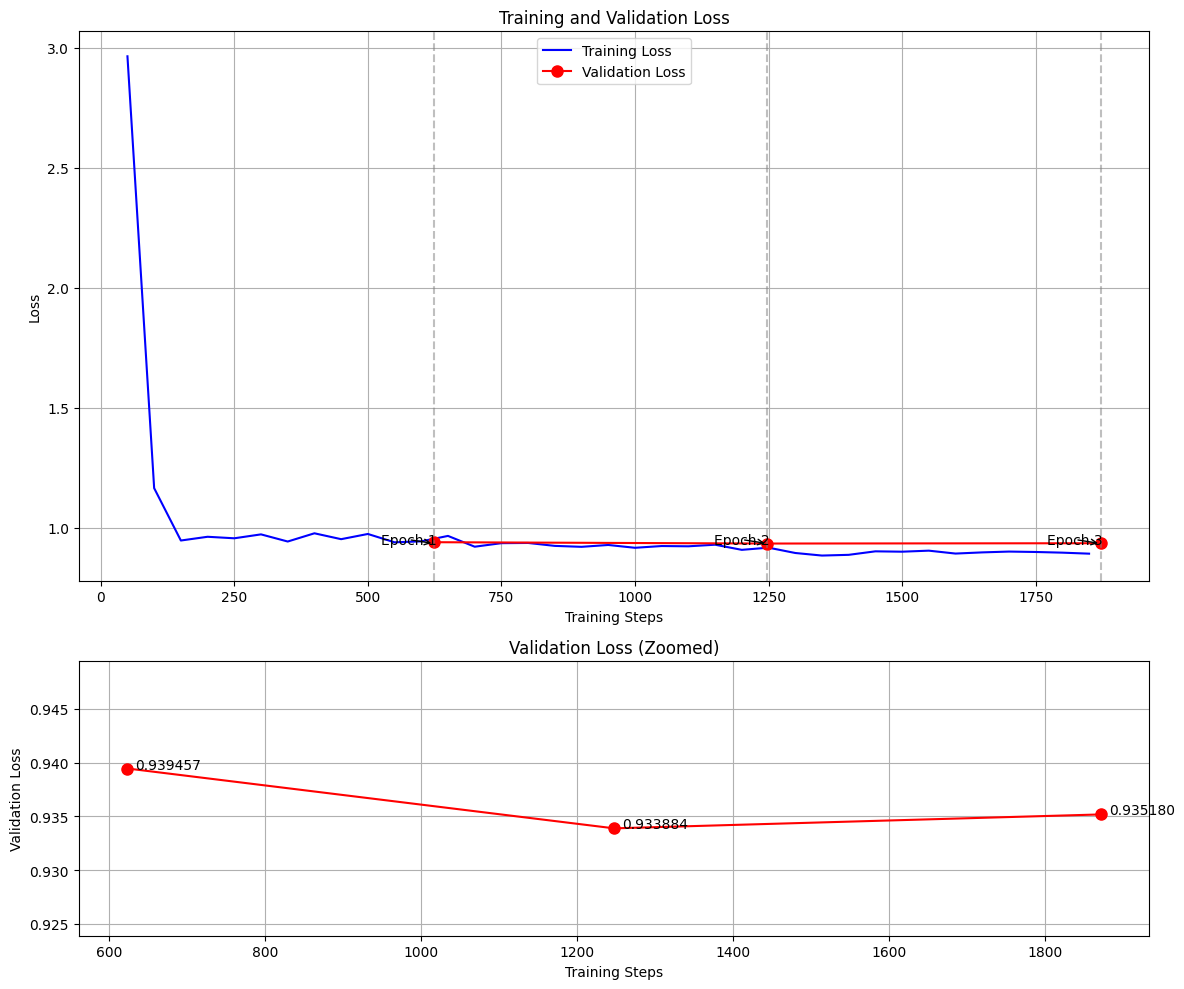


Loss at each epoch end:
Epoch 1 (Step 624): Training Loss = 0.943000, Validation Loss = 0.939457
Epoch 2 (Step 1248): Training Loss = 0.916700, Validation Loss = 0.933884
Epoch 3 (Step 1872): Training Loss = 0.891700, Validation Loss = 0.935180

Validation Loss Changes:
Epoch 1 → 2: 0.939457 → 0.933884 (Change: -0.005573, -0.59%)
Epoch 2 → 3: 0.933884 → 0.935180 (Change: 0.001296, +0.14%)
Final training loss: 0.891700
Final validation loss: 0.935180


In [9]:
# Load training history
history_path = os.path.join(model_path, "trainer_state.json")
print(f"Loading training history from {history_path}")

with open(history_path, "r") as f:
    training_history = json.load(f)

# Extract all loss values with their steps
steps = []
train_losses = []
eval_steps = []
eval_losses = []

for entry in training_history["log_history"]:
    if "loss" in entry and "eval_loss" not in entry:
        steps.append(entry.get("step", 0))
        train_losses.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry.get("step", 0))
        eval_losses.append(entry["eval_loss"])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Full training and validation loss
ax1.plot(steps, train_losses, 'b-', label="Training Loss")
ax1.plot(eval_steps, eval_losses, 'ro-', label="Validation Loss", markersize=8)

# Add epoch boundaries
for epoch_end in eval_steps:
    ax1.axvline(x=epoch_end, color='gray', linestyle='--', alpha=0.5)

# Add labels and title
ax1.set_xlabel("Training Steps")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(True)

# Add annotations for epoch ends
for i, step in enumerate(eval_steps):
    ax1.annotate(f"Epoch {i+1}", 
                xy=(step, min(train_losses) + 0.05), 
                xytext=(step-100, min(train_losses) + 0.05),
                arrowprops=dict(arrowstyle="->"))

# Plot 2: Zoomed in on validation loss
ax2.plot(eval_steps, eval_losses, 'ro-', label="Validation Loss", markersize=8)
for i, (step, loss) in enumerate(zip(eval_steps, eval_losses)):
    ax2.annotate(f"{loss:.6f}", 
                xy=(step, loss), 
                xytext=(step+10, loss),
                fontsize=10)

# Set y-axis limits to zoom in on validation loss
min_val = min(eval_losses) - 0.01
max_val = max(eval_losses) + 0.01
ax2.set_ylim(min_val, max_val)

# Add labels
ax2.set_xlabel("Training Steps")
ax2.set_ylabel("Validation Loss")
ax2.set_title("Validation Loss (Zoomed)")
ax2.grid(True)

plt.tight_layout()
plt.show()


# Print loss at each epoch end
print("\nLoss at each epoch end:")
for i, (step, eval_loss) in enumerate(zip(eval_steps, eval_losses)):
    # Find the closest training loss to this step
    closest_idx = min(range(len(steps)), key=lambda i: abs(steps[i] - step))
    train_loss = train_losses[closest_idx]
    print(f"Epoch {i+1} (Step {step}): Training Loss = {train_loss:.6f}, Validation Loss = {eval_loss:.6f}")


# Calculate validation loss changes
if len(eval_losses) > 1:
    print("\nValidation Loss Changes:")
    for i in range(1, len(eval_losses)):
        change = eval_losses[i] - eval_losses[i-1]
        percent = (change / eval_losses[i-1]) * 100
        print(f"Epoch {i} → {i+1}: {eval_losses[i-1]:.6f} → {eval_losses[i]:.6f} " +
              f"(Change: {change:.6f}, {percent:+.2f}%)")

# Print final losses
print(f"Final training loss: {train_losses[-1]:.6f}")
print(f"Final validation loss: {eval_losses[-1]:.6f}")



# 6. Evaluate on Test Data     

In [10]:
# Visualize the test procedure using just some examples 

# Load test data
print(f"Loading test data from {test_data_path}...")
with open(test_data_path, "r") as f:
    test_data = json.load(f)
print(f"Loaded {len(test_data)} test examples")

# Evaluate on a subset first (for quick testing)
max_examples = 5  # Adjust here!
print(f"Evaluating on {max_examples} examples (out of {len(test_data)})")
test_subset = test_data[:max_examples]

print(test_subset)

predictions = []
true_labels = []
examples = []

for i, example in enumerate(test_subset):
    print(f"Processing example {i+1}/{len(test_subset)}")
        
    # Get model prediction
    instruction = example["instruction"]
    response = generate_response(instruction)
    
    print(f"instruction: {instruction}")
    print(f"response: {response}")

    # Process prediction to extract slang/no-slang classification
    prediction = 0 if "no slang detected" in response.lower() else 1 
    print(f"prediction: {prediction}")
    
    # Get ground truth
    ground_truth = 0 if "no slang detected" in example["output"].lower() else 1
    print(f"test_subset output: {example['output']}")
    print(f"ground_truth: {ground_truth}")

    predictions.append(prediction)
    true_labels.append(ground_truth)
    
    # Save example for analysis
    examples.append({
        "instruction": instruction,
        "model_response": response,
        "prediction": prediction,
        "ground_truth": ground_truth,
        "correct": prediction == ground_truth
    })

Loading test data from c:\Users\jiang\Desktop\Projects\Lingo\data\processed\text\test.json...
Loaded 1248 test examples
Evaluating on 5 examples (out of 1248)
[{'instruction': 'Identify any slang in this video subtitle: "She aint gonna fight you."', 'input': '', 'output': "slang detected: ain't\nslang context: She aint gonna fight you."}, {'instruction': 'Identify any slang in this video subtitle: "Yeah, there\'s been none of that on the trip."', 'input': '', 'output': "slang detected: yeah\nslang context: Yeah, there's been none of that on the trip."}, {'instruction': 'Identify any slang in this video subtitle: "Now I\'ve got your fucking little weasel of a brother trying to turn Bluey against me."', 'input': '', 'output': "slang detected: fucking\nslang context: Now I've got your fucking little weasel of a brother trying to turn Bluey against me."}, {'instruction': 'Identify any slang in this video subtitle: "I thought maybe, by coming back here,"', 'input': '', 'output': 'no slang d

In [14]:
# Test with all examples and use this to calculate metrics

print(f"Loading test data from {test_data_path}...")
with open(test_data_path, "r") as f:
    test_data = json.load(f)
print(f"Loaded {len(test_data)} test examples")

# Evaluate on a subset first (for quick testing)
max_examples = 500  # Adjust here!
print(f"Evaluating on {max_examples} examples (out of {len(test_data)})")
test_subset = test_data[:max_examples]

# print(test_subset)

predictions = []
true_labels = []
examples = []

# Add time tracking
import time
start_time = time.time()

for i, example in enumerate(test_subset):
    # Print progress every 100 examples
    if i % 100 == 0:
        elapsed = time.time() - start_time
        print(f"Progress: {i}/{len(test_data)} examples processed ({i/len(test_data)*100:.1f}%) - Elapsed time: {elapsed:.1f}s")
                
    # Get model prediction
    instruction = example["instruction"]
    response = generate_response(instruction)
    
    # print(f"instruction: {instruction}")
    # print(f"response: {response}")

    # Process prediction to extract slang/no-slang classification
    prediction = 0 if "no slang detected" in response.lower() else 1 
    #print(f"prediction: {prediction}")
    
    # Get ground truth
    ground_truth = 0 if "no slang detected" in example["output"].lower() else 1
    # print(f"test_subset output: {example['output']}")
    # print(f"ground_truth: {ground_truth}")

    predictions.append(prediction)
    true_labels.append(ground_truth)
    
    # Save example for analysis
    examples.append({
        "instruction": instruction,
        "model_response": response,
        "prediction": prediction,
        "ground_truth": ground_truth,
        "correct": prediction == ground_truth
    })

Loading test data from c:\Users\jiang\Desktop\Projects\Lingo\data\processed\text\test.json...
Loaded 1248 test examples
Evaluating on 500 examples (out of 1248)
Progress: 0/1248 examples processed (0.0%) - Elapsed time: 0.0s


c:\Users\jiang\anaconda3\envs\lingo_win\lib\site-packages\transformers\generation\configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\jiang\anaconda3\envs\lingo_win\lib\site-packages\transformers\generation\configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
c:\Users\jiang\anaconda3\envs\lingo_win\lib\site-packages\transformers\generation\configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Progress: 100/1248 examples processed (8.0%) - Elapsed time: 129.6s
Progress: 200/1248 examples processed (16.0%) - Elapsed time: 233.3s
Progress: 300/1248 examples processed (24.0%) - Elapsed time: 373.4s
Progress: 400/1248 examples processed (32.1%) - Elapsed time: 498.4s


# 7. Calculate and Display Metrics

In [12]:
# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
report = classification_report(true_labels, predictions)

print("\n" + "="*50)
print("Evaluation Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nDetailed Classification Report:")
print(report)


Evaluation Results:
Precision: 0.7666
Recall: 0.7864
F1 Score: 0.7764

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.63       191
           1       0.77      0.79      0.78       309

    accuracy                           0.72       500
   macro avg       0.70      0.70      0.70       500
weighted avg       0.72      0.72      0.72       500



# 8. Trying to make an Interactive Demo

In [13]:
# # Simple interactive demo
# def test_custom_input():
#     user_input = input("Enter text to check for slang (or 'quit' to exit): ")
#     if user_input.lower() == 'quit':
#         return False
    
#     print("\nGenerating response...")
#     response = generate_response(user_input)
#     print(f"\nModel response:\n{response}")
#     print("-" * 50)
#     return True

# print("\n" + "="*50)
# print("Interactive Slang Detection Demo")
# print("Type 'quit' to exit")
# print("="*50 + "\n")

# while test_custom_input():
#     pass